# Transfer learning for Glaucoma and Normal Eye Fundus

## General libraries

In [1]:
import os
import csv
import PIL
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.models import load_model, model_from_json, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Sklearn
from sklearn.model_selection import train_test_split

In [2]:
# Check Tensorflow version

print('Current Tensorflow version:', tf.__version__)

Current Tensorflow version: 2.10.0


In [3]:
# Check GPUs availability

print('Num GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 1


In [4]:
# Check Cuda availability

print('Built with CUDA:', tf.test.is_built_with_cuda())
print('Built with GPU support:', tf.test.is_built_with_gpu_support())
print('List physical devices:\n', tf.config.list_physical_devices())
print('List logical devices:\n', tf.config.list_logical_devices())

Built with CUDA: True
Built with GPU support: True
List physical devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
List logical devices:
 [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]


## Data exploration

### Set the base directory

In [5]:
# Set the base directory

main_project_dir = 'D:\Kuliah\Proyek Akhir 2022'
main_dataset_dir = os.path.join(main_project_dir, 'Dataset')
dataset_dir = os.path.join(main_dataset_dir, 'Dataset (Glaucoma-Normal) (Splitted)')

def is_directory_exists(path):
    if os.path.exists(path):
        print(f'"{path}" directory is exist')
    else:
        print(f'"{path}" directory is not exist')

is_directory_exists(main_project_dir)
is_directory_exists(main_dataset_dir)
is_directory_exists(dataset_dir)

print('\nProject directory:', main_project_dir)
print('Main dataset directory:', main_dataset_dir)
print('Used dataset directory:', dataset_dir)

"D:\Kuliah\Proyek Akhir 2022" directory is exist
"D:\Kuliah\Proyek Akhir 2022\Dataset" directory is exist
"D:\Kuliah\Proyek Akhir 2022\Dataset\Dataset (Glaucoma-Normal) (Splitted)" directory is exist

Project directory: D:\Kuliah\Proyek Akhir 2022
Main dataset directory: D:\Kuliah\Proyek Akhir 2022\Dataset
Used dataset directory: D:\Kuliah\Proyek Akhir 2022\Dataset\Dataset (Glaucoma-Normal) (Splitted)


In [6]:
os.getcwd()

'd:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model'

### Explore original dataset

In [7]:
# Create function to generate CSV file based on dataset directory

def create_csv_file_from_dataset(filename, path, headers, dataset_source, dataset_type=''):
    supported_extensions = ['.png', '.jpg', '.jpeg']
    file_path = os.path.join(path, filename)

    try:
        with open(file_path, 'w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(headers)
        
        for root, dirs, files in os.walk(dataset_source + '/' + dataset_type):
            for file in files:
                if any(file.lower().endswith(ext) for ext in supported_extensions):
                    image_path = os.path.join(root, file)
                    label = os.path.basename(root)
                    with open(file_path, 'a', newline='') as csv_file:
                        writer = csv.writer(csv_file)
                        writer.writerow([file, label])
        
        print('Generating CSV file is completed.')
    except (FileNotFoundError, PermissionError) as e:
        print(f'An error occured: {e}')
    finally:
        csv_file.close()
    
    print(f'CSV file successfully created in "{file_path}"')

In [8]:
# Create the glaucoma normal splitted dataset CSV

csv_file_name = 'glaucoma_normal_splitted_dataset.csv'
csv_path = main_dataset_dir
dataset_source = os.path.join(csv_path, 'Dataset (Glaucoma-Normal)')
headers = ['Image', 'Label']

create_csv_file_from_dataset(csv_file_name, csv_path, headers, dataset_source)

Generating CSV file is completed.
CSV file successfully created in "D:\Kuliah\Proyek Akhir 2022\Dataset\glaucoma_normal_splitted_dataset.csv"


In [9]:
# Load the CSV dataset file

glaucoma_df = pd.read_csv(os.path.join(main_dataset_dir, csv_file_name))
glaucoma_df

Image     Label
0               BEH-1.png  Glaucoma
1              BEH-10.png  Glaucoma
2             BEH-100.png  Glaucoma
3             BEH-101.png  Glaucoma
4             BEH-102.png  Glaucoma
...                   ...       ...
9529  sjchoi86-HRF-89.png    Normal
9530  sjchoi86-HRF-91.png    Normal
9531  sjchoi86-HRF-93.png    Normal
9532  sjchoi86-HRF-97.png    Normal
9533  sjchoi86-HRF-98.png    Normal

[9534 rows x 2 columns]

In [10]:
# Show dataset dataframe properties

def show_dataset_properties(dataset_df):
    print('glaucoma_df shape  :', glaucoma_df.shape)
    print('glaucoma_df axes   :', glaucoma_df.axes)
    print('glaucoma_df labels :', glaucoma_df['Label'].unique())

    print('\nNumber of images in each class:\n', glaucoma_df.groupby('Label')['Image'].nunique())

    label_count = glaucoma_df.groupby('Label')['Image'].nunique()
    label_count = label_count.to_numpy()
    print('\nGlaucoma images :', label_count[0])
    print('Normal images   :', label_count[1])

In [11]:
show_dataset_properties(glaucoma_df)

glaucoma_df shape  : (9534, 2)
glaucoma_df axes   : [RangeIndex(start=0, stop=9534, step=1), Index(['Image', 'Label'], dtype='object')]
glaucoma_df labels : ['Glaucoma' 'Normal']

Number of images in each class:
 Label
Glaucoma    4767
Normal      4767
Name: Image, dtype: int64

Glaucoma images : 4767
Normal images   : 4767


In [12]:
# Create function to plot dataset count in each class

def plot_dataset(dataset_df, title, figsize=(7, 6)):
    category_counts = dataset_df['Label'].value_counts()

    plt.figure(figsize=figsize)
    ax = category_counts.plot(kind='bar')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(title)

    for i, count in enumerate(category_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.setp(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()

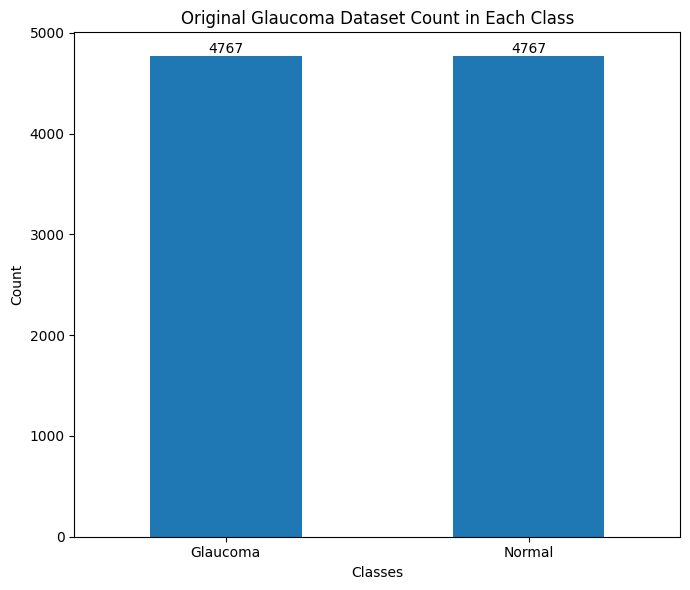

In [13]:
# Plotting the dataset count in each class

plot_title = 'Original Glaucoma Dataset Count in Each Class'
plot_dataset(glaucoma_df, plot_title)

In [14]:
# Set the train, val, and test dataset path

train_url = os.path.join(dataset_dir, 'train')
val_url = os.path.join(dataset_dir, 'val')
test_url = os.path.join(dataset_dir, 'test')

# Using pathlib so we can iterate and count images inside the directory

train_dir = pathlib.Path(train_url)
val_dir = pathlib.Path(val_url)
test_dir = pathlib.Path(test_url)

print('Train directory\t:', train_dir)
print('Val directory\t:', val_dir)
print('Test directory\t:', test_dir)

Train directory	: D:\Kuliah\Proyek Akhir 2022\Dataset\Dataset (Glaucoma-Normal) (Splitted)\train
Val directory	: D:\Kuliah\Proyek Akhir 2022\Dataset\Dataset (Glaucoma-Normal) (Splitted)\val
Test directory	: D:\Kuliah\Proyek Akhir 2022\Dataset\Dataset (Glaucoma-Normal) (Splitted)\test


In [15]:
# Image count in each dataset

train_count = len(list(train_dir.glob('*/*')))
val_count = len(list(val_dir.glob('*/*')))
test_count = len(list(test_dir.glob('*/*')))

print('Total training set images\t:', train_count)
print('Total validation set images\t:', val_count)
print('Total test set images\t\t:', test_count)

Total training set images	: 9056
Total validation set images	: 238
Total test set images		: 240


In [16]:
# Create dictionary from each dataset

data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}

data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

### Plot the class distribution

Train information
---------------
Label names		: ['Glaucoma', 'Normal']
Label counts		: [4528, 4528]
Total image count	: 9056 

Val information
---------------
Label names		: ['Glaucoma', 'Normal']
Label counts		: [119, 119]
Total image count	: 238 

Test information
---------------
Label names		: ['Glaucoma', 'Normal']
Label counts		: [120, 120]
Total image count	: 240 



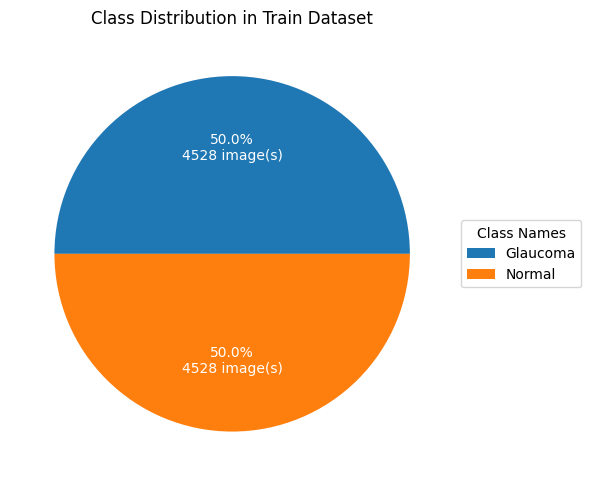

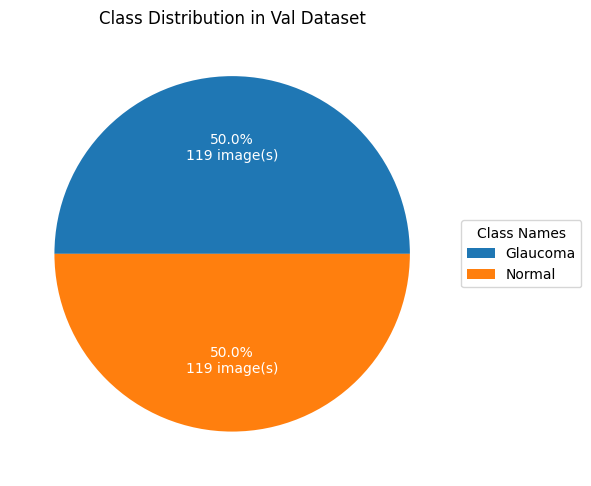

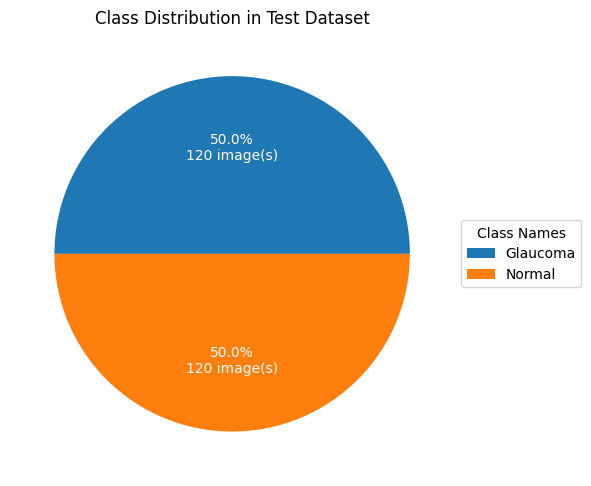

In [17]:
# Set and plot each dataset's classes distribution

for phase in ['train', 'val', 'test']:
    if phase == 'train':
        data_dir = train_dir
    elif phase == 'val':
        data_dir = val_dir
    elif phase == 'test':
        data_dir = test_dir

    # Find the class names and the class length
    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names) 

    # Create the image file list from each class
    image_files = [[
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ] for i in range(num_class)]

    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = [] 
    image_class = []

    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])

    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    
    print(f'{phase.capitalize()} information')
    print('-'*15)
    print(f'Label names\t\t: {class_names}')
    print(f'Label counts\t\t: {num_each}')
    print(f'Total image count\t: {num_total}', '\n')

    def func(pct, allvals):
        absolute = int(np.round(pct/100.*np.sum(allvals)))
        return f"{pct:.1f}%\n{absolute:d} image(s)"

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
    wedges, texts, autotexts = ax.pie(num_each, 
                                      labels=class_names, 
                                      autopct=lambda pct: func(pct, num_each), 
                                      textprops=dict(color='w'))
    ax.legend(wedges, 
              class_names,
              title='Class Names',
              loc='center left',
              bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(f'Class Distribution in {phase.capitalize()} Dataset')
    plt.tight_layout()

In [18]:
def plot_class_distribution_bar_chart(dataset_dir):
    dataset_types = ['train', 'val', 'test']

    for dataset_type in dataset_types:
        classes = []
        counts = []

        # Iterate over the directories in the dataset type directory
        for root, dirs, files in os.walk(os.path.join(dataset_dir, dataset_type)):
            for dir_name in dirs:
                # Get the class name and count the number of images
                class_name = dir_name
                image_count = len(os.listdir(os.path.join(root, dir_name)))
                classes.append(class_name)
                counts.append(image_count)

        # Plot the chart
        plt.figure(figsize=(6, 5))

        if len(classes) <= 10:
            # If there are fewer than or equal to 10 classes, plot a bar chart
            plt.bar(classes, counts)
            plt.xlabel('Class')
            plt.ylabel('Count')
            plt.title('Class Distribution in ' + dataset_type.capitalize() + ' Dataset')

            for i in range(len(classes)):
                plt.text(i, counts[i], str(counts[i]), ha='center', va='bottom')
        else:
            # If there are more than 10 classes, plot a pie chart
            plt.pie(counts, labels=classes, autopct='%1.1f%%')
            plt.title('Class Distribution in ' + dataset_type.capitalize() + ' Dataset')

        plt.tight_layout()
        plt.show()

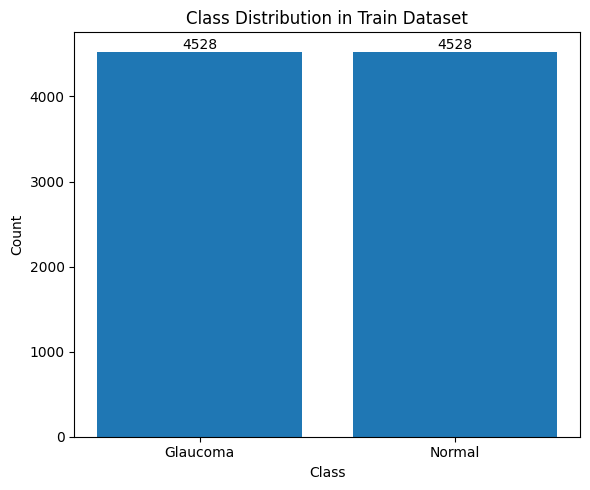

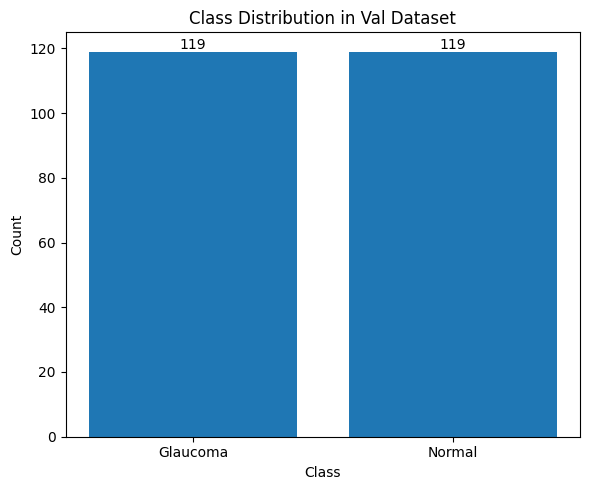

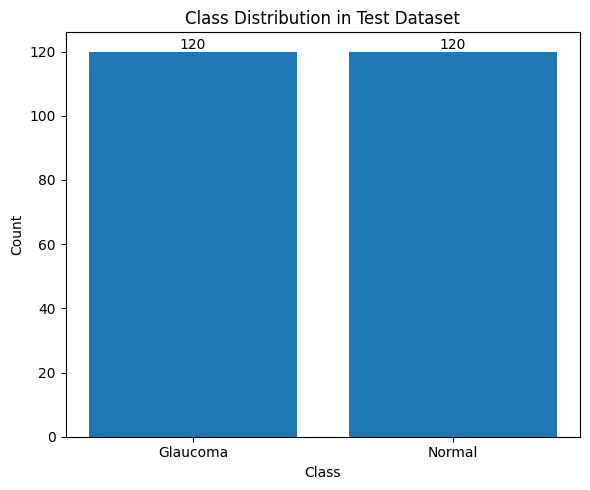

In [19]:
plot_class_distribution_bar_chart(dataset_dir)

In [20]:
def plot_class_distribution_grouped_bar_chart(dataset_dir):
    classes = []
    counts_train = []
    counts_val = []
    counts_test = []

    # Iterate over the directories in the train dataset
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'train')):
        for dir_name in dirs:
            class_name = dir_name
            image_count = len(os.listdir(os.path.join(root, dir_name)))
            classes.append(class_name)
            counts_train.append(image_count)

    # Iterate over the directories in the val dataset
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'val')):
        for dir_name in dirs:
            class_name = dir_name
            image_count = len(os.listdir(os.path.join(root, dir_name)))
            counts_val.append(image_count)

    # Iterate over the directories in the test dataset
    for root, dirs, files in os.walk(os.path.join(dataset_dir, 'test')):
        for dir_name in dirs:
            class_name = dir_name
            image_count = len(os.listdir(os.path.join(root, dir_name)))
            counts_test.append(image_count)

    # Create an array to store the x-axis positions
    x_positions = np.arange(len(classes))

    # Set the width of each bar
    bar_width = 0.25

    # Plot the grouped bars
    plt.figure(figsize=(8, 6))
    plt.bar(x_positions - bar_width, counts_train, width=bar_width, label='Train')
    plt.bar(x_positions, counts_val, width=bar_width, label='Val')
    plt.bar(x_positions + bar_width, counts_test, width=bar_width, label='Test')

    # Set the x-axis labels
    plt.xticks(x_positions, classes)

    # Add the numbers of each dataset to the bars
    for i, count in enumerate(counts_train):
        plt.text(i - bar_width, count, str(count), ha='center', va='bottom')
    for i, count in enumerate(counts_val):
        plt.text(i, count, str(count), ha='center', va='bottom')
    for i, count in enumerate(counts_test):
        plt.text(i + bar_width, count, str(count), ha='center', va='bottom')

    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Image Counts by Class and Dataset Type')
    plt.legend()

    plt.tight_layout()
    plt.show()


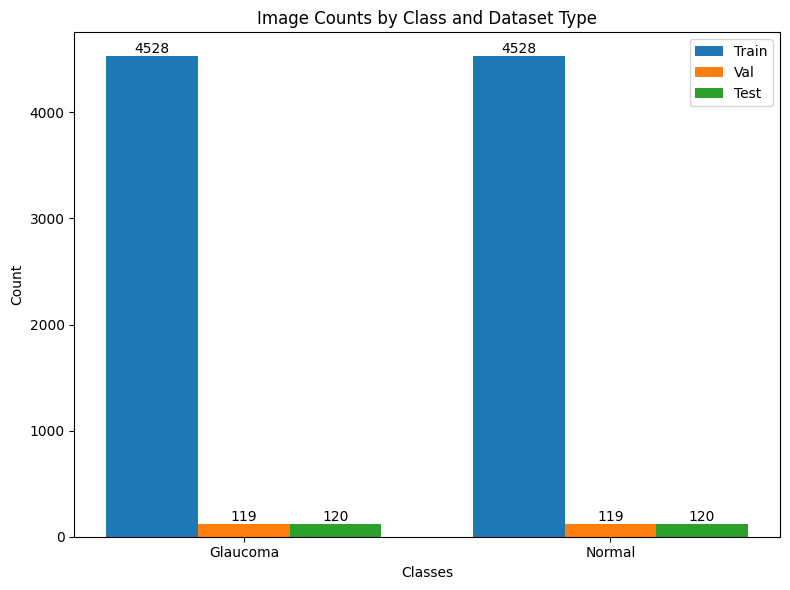

In [21]:
plot_class_distribution_grouped_bar_chart(dataset_dir)

## Data loading & augmentation

### Set some training parameters

In [22]:
# Set some training hyperparameters

BATCH_SIZE = 32

IMG_SIZE_1 = 32
IMG_SIZE_2 = 64
IMG_SIZE_3 = 100
IMG_SIZE_4 = 128
IMG_SIZE_5 = 180
IMG_SIZE_6 = 224
IMG_SIZE_7 = 256
IMG_SIZE = (IMG_SIZE_3, IMG_SIZE_3)

print('BATCH_SIZE:', BATCH_SIZE)
print('IMG_SIZE:', IMG_SIZE, '| IMG_SIZE type:', type(IMG_SIZE))

BATCH_SIZE: 32
IMG_SIZE: (100, 100) | IMG_SIZE type: <class 'tuple'>


In [23]:
# Import the preprocessing input function from the model to be used

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [24]:
# Create the datagen for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

datagen = {
    'train': ImageDataGenerator(
        # rescale=1/255.0,
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='constant',
        # shear_range=5.0,
        # zoom_range=[0.5, 1.0],
        # brightness_range=(0.5, 1.5),
        # width_shift_range=(0.0, 0.15),
        # height_shift_range=(0.0, 0.15),
        # preprocessing_input=preprocess_input

    ),
    'val': ImageDataGenerator(
        # rescale=1/255.0,
    ),
    'test': ImageDataGenerator(
        # rescale=1/255.0,
    ),
}

In [25]:
# Create the image generator for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

test_image_source = 'glaucoma_test_images/EyePACS-Glaucoma-126.png'
augmentation_dest_path = 'glaucoma_augmentations_examples'

data_sets = {
    'train': datagen['train'].flow_from_directory(
        train_dir, 
        shuffle=True, 
        seed=42, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,

        # Uncomment these lines if we want to preview and save some augmented images
        # save_to_dir=augmentation_dest_path,
        # save_prefix='aug',
        # save_format='png'
    ),
    'val': datagen['val'].flow_from_directory(
        val_dir, 
        shuffle=True, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,
    ),
    'test': datagen['test'].flow_from_directory(
        test_dir, 
        shuffle=False, 
        class_mode='binary', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE
    )
}

Found 9056 images belonging to 2 classes.
Found 238 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [27]:
# Uncomment this cell if we want to preview and save some augmented images

# 
# test_image_source = 'glaucoma_test_images/EyePACS-Glaucoma-126.png'
# augmentation_dest_path = 'glaucoma_augmentations_examples'
# 
# i = 0
# 
# for batch in data_sets['train']:
#     i = i + 1
#     if i >= 30:
#         break

### Preview images from each dataset

In [28]:
def show_images_from_dataset(dataset_type):
    if dataset_type not in ['train', 'val', 'test']:
        raise ValueError("Invalid dataset_type. Choose 'train', 'val', or 'test'.")

    # Get a batch of images and their labels
    images, labels = next(data_sets[dataset_type])

    # Configure the figure for plotting
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Plot each image with its corresponding label
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img.astype('uint8'))
        ax.set_title(f"Class: {class_names[int(label)]}")
        ax.axis('on')
    
    if dataset_type == 'train':
        plt.suptitle('Preprocessed/Augmented Train Images')
    elif dataset_type == 'val':
        plt.suptitle('Preprocessed/Augmented Validation Images')
    elif dataset_type == 'test':
        plt.suptitle('Preprocessed/Augmented Test Images')

    # Show the plot
    plt.tight_layout()
    plt.show()

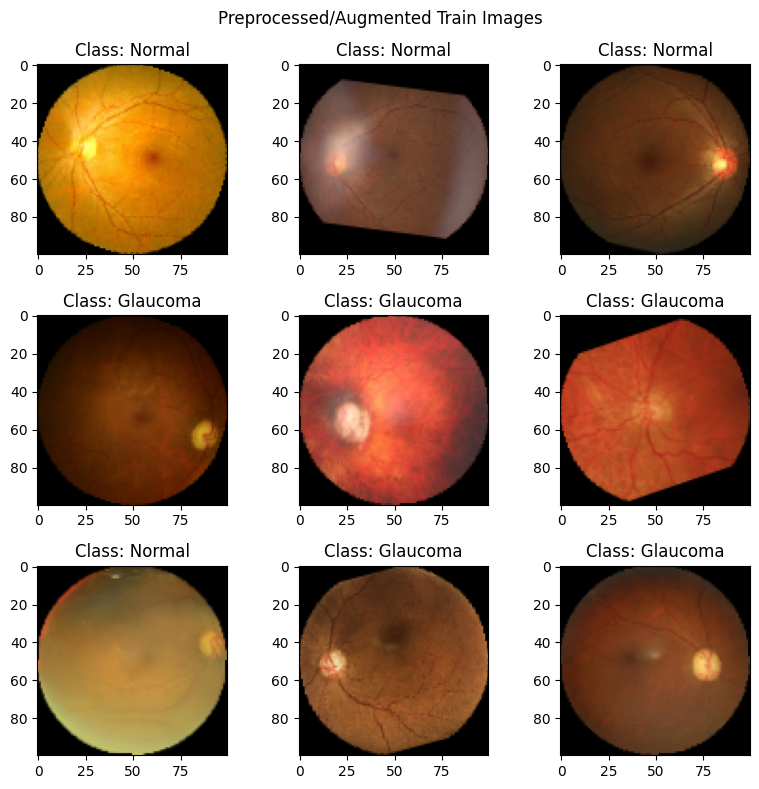

In [29]:
# Check and show images from training data generator

show_images_from_dataset('train')

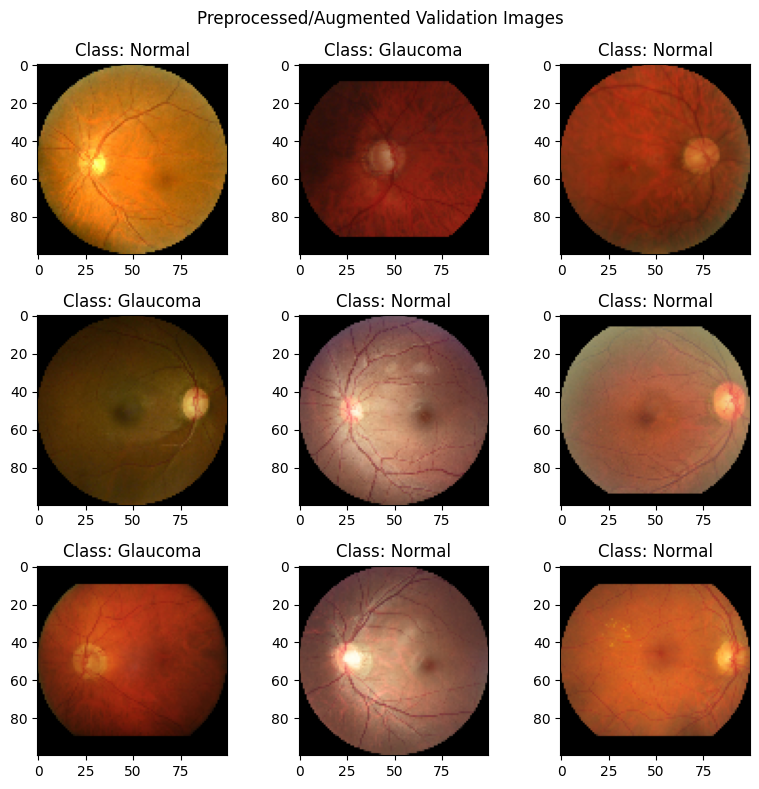

In [30]:
# Check and show images from validation data generator

show_images_from_dataset('val')

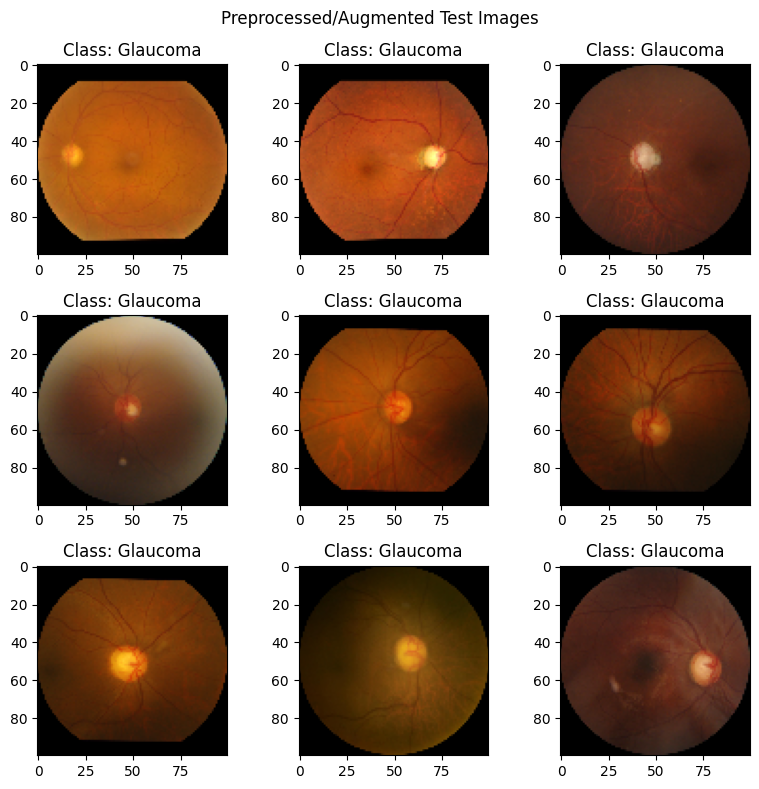

In [31]:
# Check and show images from test data generator

show_images_from_dataset('test')

## Create the base model

In [32]:
# Create the base model from the pre-trained model - EfficientNetV2B2

IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetV2B2(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

## Feature extraction

### Freeze the trainable layers

In [33]:
# Freeze the trainable layers

base_model.trainable = False

In [34]:
# Take a look at the base model architecture

base_model.summary()

Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 100, 100, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 100, 100, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 50, 50, 32)   864         ['normalization[0

### Add additional top layers

In [35]:
# Create the whole model with some additional top layers

model = tf.keras.Sequential()
model.add(base_model)

# These layers could be modified for further experiments
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # 1 unit because this is a binary classification

In [36]:
# Take a look at the new whole model architecture now
# Based on layers that we have added in the code above, we can observe from the model summary in 
# "trainable params" section that there are additional layers 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 4, 4, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

### Compile the model

In [37]:
BASE_LR = 0.0001

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR), # Optimizers could be changed for further experiments
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [38]:
# Check again whether this model summary is different from before or not

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 4, 4, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [108]:
len(model.trainable_variables)

8

In [39]:
# Try to evaluate the model using validation dataset before training process

loss0, accuracy0 = model.evaluate(data_sets['val'])

print("Initial loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

8/8 [==============================] - 13s 371ms/step - loss: 0.6990 - accuracy: 0.5042
Initial loss: 0.70
Initial accuracy: 0.50


### Define some model callbacks

In [40]:
# Define some callbacks for the model

trained_model_path = 'trained_model'

# Model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(trained_model_path, 'efficientnetv2b2_glaucoma_best_model_2.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # This could be changed in the future for further experiments
    verbose=1,
    restore_best_weights=True,
    min_delta=0.1 # This could be changed in the future for further experiments
)

# Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8,
    patience=3, 
    min_lr=1e-5, 
    verbose=1
)

# Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard(os.path.join(trained_model_path, 'tb_logs/run_logs'))

### Train the whole model

In [41]:
INIT_EPOCH = 30 # This could be changed for further experiments

history = model.fit(
    data_sets['train'],
    epochs=INIT_EPOCH,
    validation_data=data_sets['val'],
    callbacks=[model_checkpoint, tensorboard]
)

Epoch 1/30
283/283 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7168
Epoch 1: val_loss improved from inf to 0.52978, saving model to trained_model\efficientnetv2b2_glaucoma_best_model_2.h5
283/283 [==============================] - 146s 464ms/step - loss: 0.5502 - accuracy: 0.7168 - val_loss: 0.5298 - val_accuracy: 0.7479
Epoch 2/30
283/283 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.7714
Epoch 2: val_loss improved from 0.52978 to 0.49000, saving model to trained_model\efficientnetv2b2_glaucoma_best_model_2.h5
283/283 [==============================] - 148s 523ms/step - loss: 0.4792 - accuracy: 0.7714 - val_loss: 0.4900 - val_accuracy: 0.7689
Epoch 3/30
283/283 [==============================] - ETA: 0s - loss: 0.4580 - accuracy: 0.7804
Epoch 3: val_loss improved from 0.49000 to 0.48289, saving model to trained_model\efficientnetv2b2_glaucoma_best_model_2.h5
283/283 [==============================] - 143s 504ms/step - loss: 0.4580 

### Learning curves

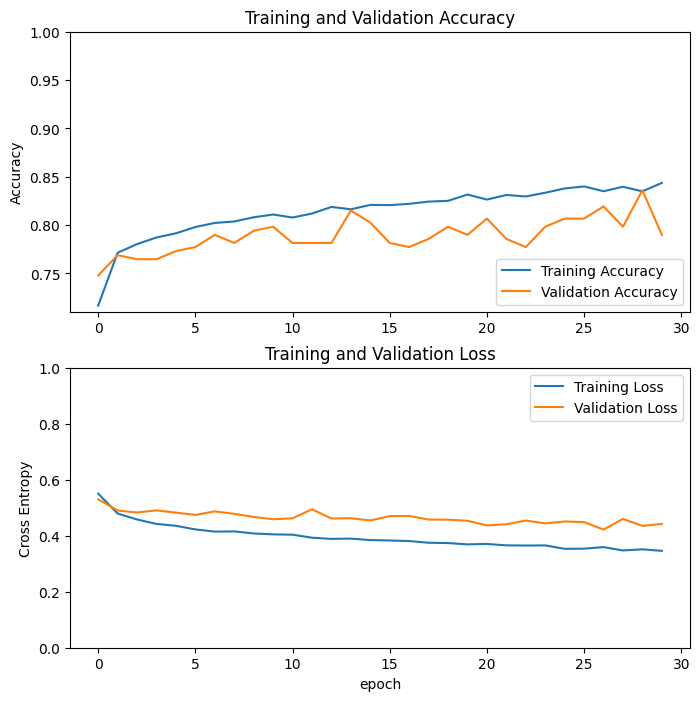

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

**Explanation of fine tuning**

In the feature extraction experiment, we were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after we have trained the top-level classifier with the pre-trained model set to non-trainable. If we add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and our pre-trained model will forget what it has learned.

Also, we should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As we go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model

In [43]:
# Un-freeze the base model

base_model.trainable = True

In [44]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model:", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100 # This could be changed for further experiments

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model: 349


### Compile the model

In [45]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=BASE_LR/10),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [46]:
# Take a final look at the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 4, 4, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               360704    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [47]:
len(model.trainable_variables)

226

### Continue training the model

In [48]:
FINE_TUNE_EPOCHS = 10 # This could be changed for further experiments
TOTAL_EPOCHS =  INIT_EPOCH + FINE_TUNE_EPOCHS

history_fine = model.fit(
    data_sets['train'],
    epochs=TOTAL_EPOCHS,
    initial_epoch=history.epoch[-1],
    validation_data=data_sets['val']
)

Epoch 30/40
283/283 [==============================] - 237s 762ms/step - loss: 0.5641 - accuracy: 0.7238 - val_loss: 0.5456 - val_accuracy: 0.7017
Epoch 31/40
283/283 [==============================] - 201s 710ms/step - loss: 0.4966 - accuracy: 0.7562 - val_loss: 0.5201 - val_accuracy: 0.7269
Epoch 32/40
283/283 [==============================] - 212s 749ms/step - loss: 0.4629 - accuracy: 0.7751 - val_loss: 0.5015 - val_accuracy: 0.7479
Epoch 33/40
283/283 [==============================] - 181s 638ms/step - loss: 0.4385 - accuracy: 0.7888 - val_loss: 0.4890 - val_accuracy: 0.7479
Epoch 34/40
283/283 [==============================] - 173s 610ms/step - loss: 0.4282 - accuracy: 0.7951 - val_loss: 0.4875 - val_accuracy: 0.7479
Epoch 35/40
283/283 [==============================] - 207s 729ms/step - loss: 0.4164 - accuracy: 0.8017 - val_loss: 0.4856 - val_accuracy: 0.7311
Epoch 36/40
283/283 [==============================] - 219s 774ms/step - loss: 0.3983 - accuracy: 0.8128 - val_loss: 0

### Learning curves after fine-tuning

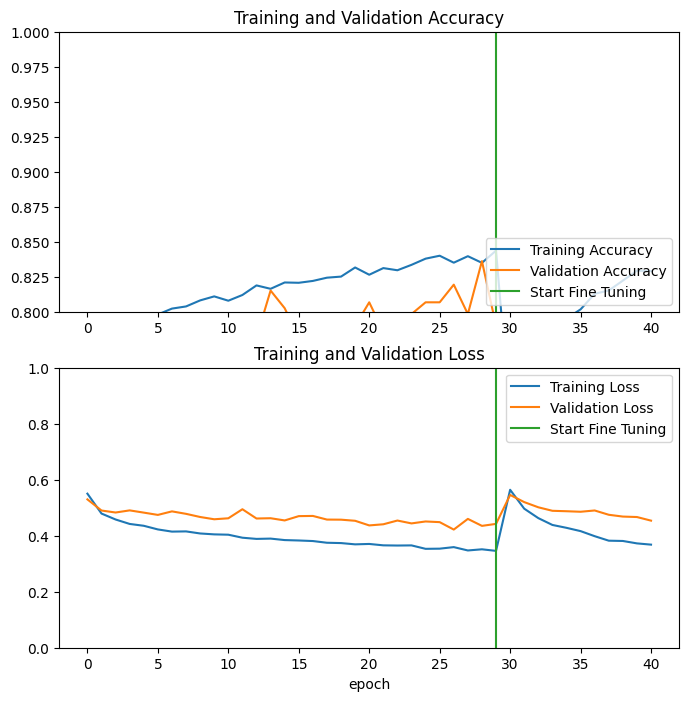

In [49]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation on test dataset

In [50]:
loss, accuracy = model.evaluate(data_sets['test'])

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2f}".format(accuracy))

8/8 [==============================] - 5s 597ms/step - loss: 0.3348 - accuracy: 0.8333
Test loss: 0.33
Test accuracy: 0.83


## Prediction on test dataset

In [51]:
predictions = model.predict(data_sets['test'])
print('Number of predicted images:', len(predictions))
print('Predictions:', predictions)
print('Predictions shape:', predictions.shape)

predictions_df = pd.DataFrame(predictions)

8/8 [==============================] - 8s 253ms/step
Number of predicted images: 240
Predictions: [[4.84109789e-01]
 [4.81526196e-01]
 [8.23779851e-02]
 [1.12158865e-01]
 [6.21859014e-01]
 [7.94321001e-01]
 [7.40232542e-02]
 [1.56005109e-02]
 [5.43572128e-01]
 [1.37225562e-03]
 [6.32436335e-01]
 [1.40608707e-03]
 [6.84266612e-02]
 [3.81654507e-04]
 [5.04925370e-01]
 [2.99974233e-02]
 [7.04964250e-02]
 [2.12145485e-02]
 [8.55840743e-03]
 [6.26226485e-01]
 [3.36258276e-03]
 [1.53646761e-04]
 [3.27762693e-01]
 [9.06625912e-02]
 [7.86935017e-02]
 [1.08675729e-03]
 [4.33680981e-01]
 [3.64161022e-02]
 [7.67618641e-02]
 [2.00707484e-02]
 [9.22497857e-05]
 [6.51117833e-03]
 [9.48892848e-05]
 [2.75063571e-02]
 [5.18249981e-02]
 [6.55515417e-02]
 [4.55231667e-02]
 [4.31151152e-01]
 [1.75175909e-02]
 [9.84155689e-04]
 [3.24272960e-02]
 [3.53411078e-01]
 [8.54120869e-03]
 [9.28816617e-01]
 [1.48235040e-03]
 [4.48834617e-03]
 [5.63030541e-01]
 [6.81360438e-03]
 [4.20387030e-01]
 [3.02118033e-01]
 [

In [52]:
predictions_df

0
0    0.484110
1    0.481526
2    0.082378
3    0.112159
4    0.621859
..        ...
235  0.989211
236  0.920623
237  0.905047
238  0.857324
239  0.838975

[240 rows x 1 columns]

In [53]:
# Add y_pred into predictions_df

predictions_df['y_pred'] = predictions_df[0].apply(lambda x: 1 if x >= 0.5 else 0)
predictions_df

0  y_pred
0    0.484110       0
1    0.481526       0
2    0.082378       0
3    0.112159       0
4    0.621859       1
..        ...     ...
235  0.989211       1
236  0.920623       1
237  0.905047       1
238  0.857324       1
239  0.838975       1

[240 rows x 2 columns]

In [54]:
# Add y_true into predictions_df

predictions_df['y_true'] = data_sets['test'].classes
predictions_df

0  y_pred  y_true
0    0.484110       0       0
1    0.481526       0       0
2    0.082378       0       0
3    0.112159       0       0
4    0.621859       1       0
..        ...     ...     ...
235  0.989211       1       1
236  0.920623       1       1
237  0.905047       1       1
238  0.857324       1       1
239  0.838975       1       1

[240 rows x 3 columns]

In [55]:
# Rename all the column headers

predictions_df.columns = ['prediction_results', 'y_pred', 'y_true']
predictions_df

prediction_results  y_pred  y_true
0              0.484110       0       0
1              0.481526       0       0
2              0.082378       0       0
3              0.112159       0       0
4              0.621859       1       0
..                  ...     ...     ...
235            0.989211       1       1
236            0.920623       1       1
237            0.905047       1       1
238            0.857324       1       1
239            0.838975       1       1

[240 rows x 3 columns]

In [56]:
# Converts y_pred into numpy array

y_pred_in_numpy = np.array(predictions_df['y_pred'])
y_pred_in_numpy

array([0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [57]:
# Converts y_true into numpy array

y_true_in_numpy = np.array(predictions_df['y_true'])
y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [59]:
# Create the glaucoma normal splitted dataset CSV

csv_file_name = 'test_glaucoma_normal_splitted_dataset.csv'
csv_path = main_dataset_dir
dataset_source = dataset_dir
headers = ['Image', 'Label']

create_csv_file_from_dataset(csv_file_name, csv_path, headers, dataset_source, dataset_type='test')

Generating CSV file is completed.
CSV file successfully created in "D:\Kuliah\Proyek Akhir 2022\Dataset\test_glaucoma_normal_splitted_dataset.csv"


In [60]:
# Load and preview the CSV dataset file

test_glaucoma_df = pd.read_csv(os.path.join(main_dataset_dir, csv_file_name))
test_glaucoma_df

Image     Label
0                BEH-147.png  Glaucoma
1                  BEH-3.png  Glaucoma
2              CRFO-v4-4.png  Glaucoma
3              CRFO-v4-8.png  Glaucoma
4    DRISHTI-GS1-test-23.png  Glaucoma
..                       ...       ...
235       REFUGE1-val-74.png    Normal
236     sjchoi86-HRF-130.png    Normal
237     sjchoi86-HRF-131.png    Normal
238     sjchoi86-HRF-193.png    Normal
239      sjchoi86-HRF-87.png    Normal

[240 rows x 2 columns]

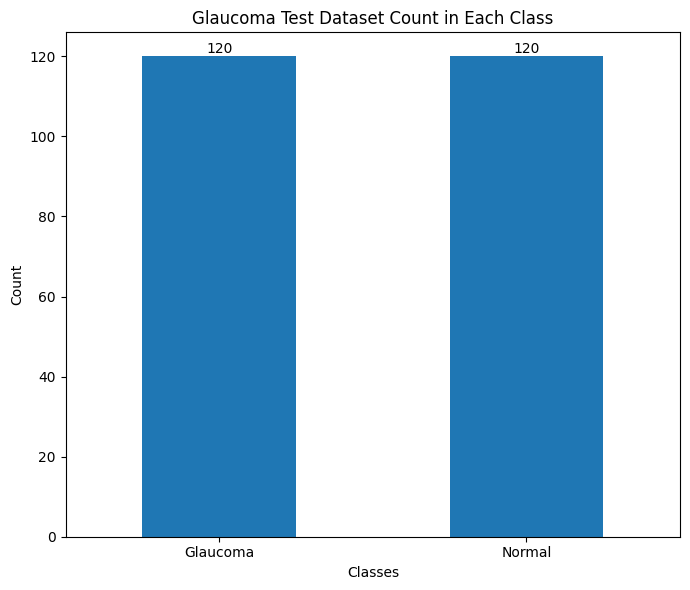

In [62]:
# Plotting the dataset count in each class

plot_title = 'Glaucoma Test Dataset Count in Each Class'
plot_dataset(test_glaucoma_df, plot_title)

In [91]:
# Preview predicted results for some images in test dataset

def show_predicted_results(dataset_df, class_label='Glaucoma'):
    sample_test = dataset_df.head(18)
    sample_test.head()
    class_indices = data_sets['test'].class_indices
    plt.figure(figsize=(10, 20))

    for index, row in sample_test.iterrows():
        filename = row['Image']
        category = row['Label']
        y_pred = predictions_df['y_pred'][index]
        classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
        if class_label == 'Glaucoma':
            img = load_img(f'{dataset_dir}/test/Glaucoma/' + filename, 
                        target_size=IMG_SIZE)
        elif class_label == 'Normal':
            img = load_img(f'{dataset_dir}/test/Normal/' + filename, 
                        target_size=IMG_SIZE)
        
        plt.subplot(6, 3, index+1)      
        plt.imshow(img)
        plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

    plt.suptitle(f'Preview Some Predicted Results on {class_label} Class')
    plt.tight_layout(pad=2)
    plt.show()

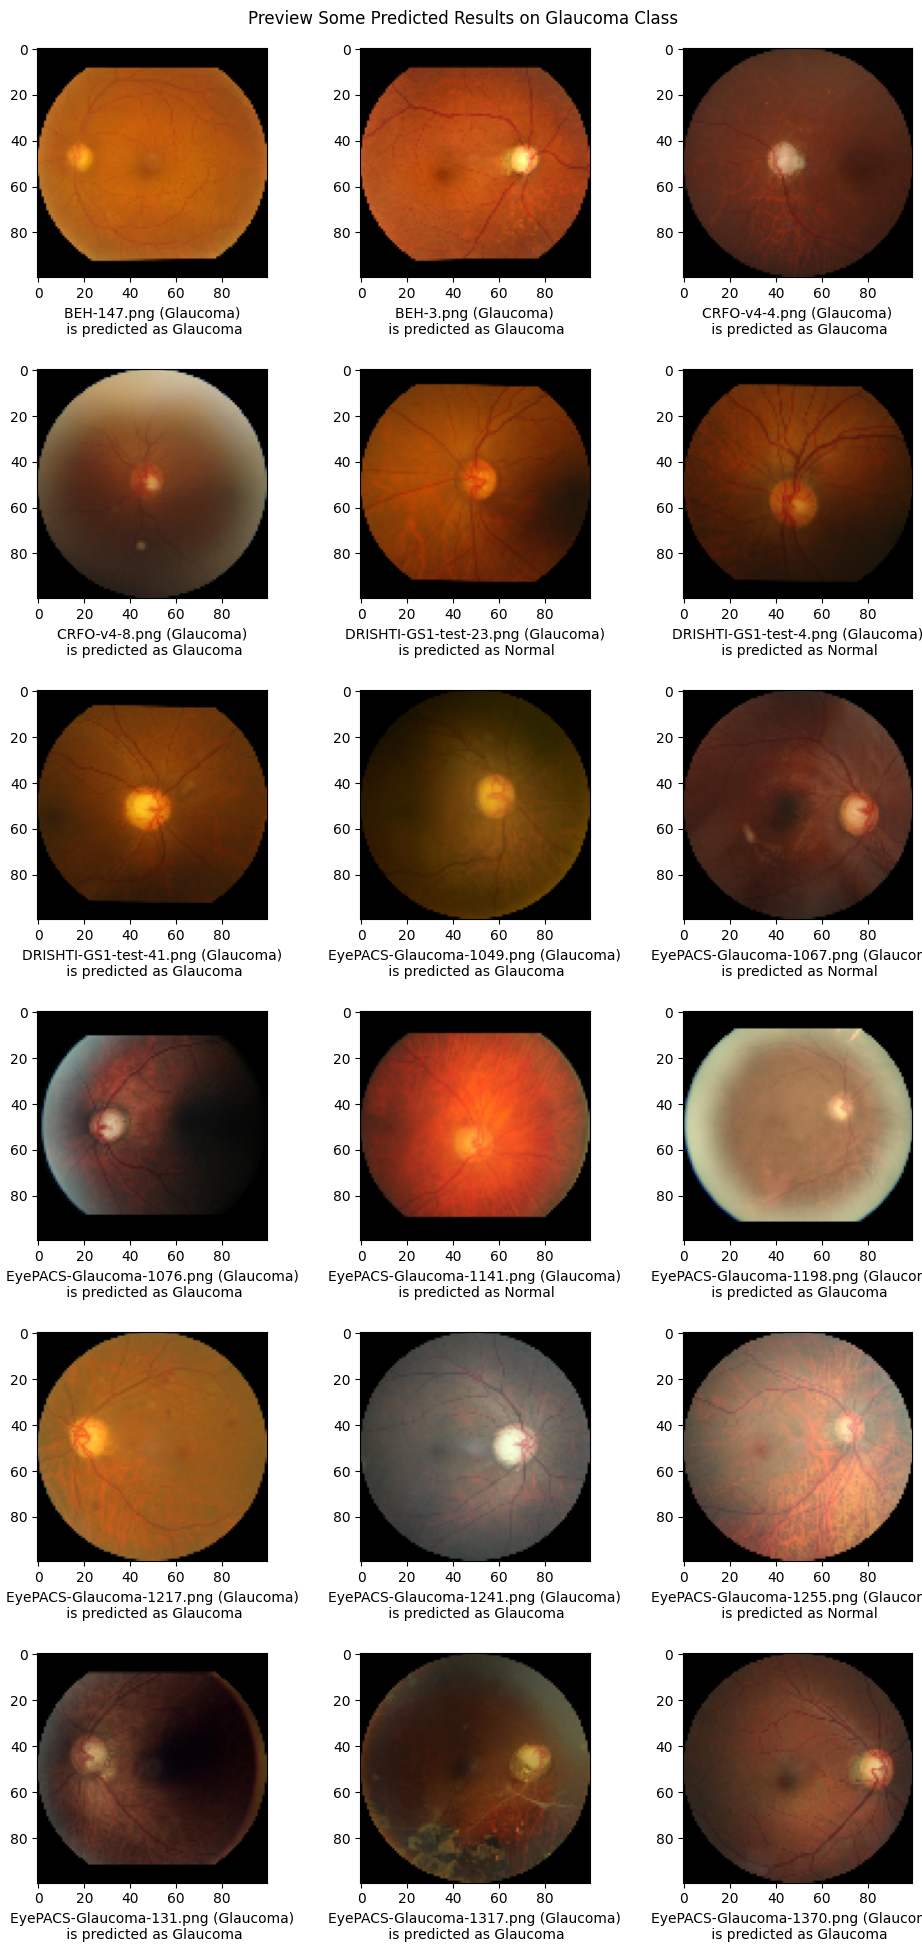

In [92]:
# Preview some glaucoma predicted results in test dataset

show_predicted_results(test_glaucoma_df, 'Glaucoma')

In [93]:
# Preview some normal eye predicted results in test dataset

# show_predicted_results(test_glaucoma_df, 'Normal')

## Evaluation metrics

In [94]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

### Classification reports

In [95]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true_in_numpy, y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true_in_numpy, y_pred_in_numpy, target_names=class_names))


Accuracy: 0.83

Micro Precision: 0.83
Micro Recall: 0.83
Micro F1-score: 0.83

Macro Precision: 0.84
Macro Recall: 0.83
Macro F1-score: 0.83

Weighted Precision: 0.84
Weighted Recall: 0.83
Weighted F1-score: 0.83


Classification Report

              precision    recall  f1-score   support

    Glaucoma       0.86      0.79      0.83       120
      Normal       0.81      0.88      0.84       120

    accuracy                           0.83       240
   macro avg       0.84      0.83      0.83       240
weighted avg       0.84      0.83      0.83       240



### Confusion matrix

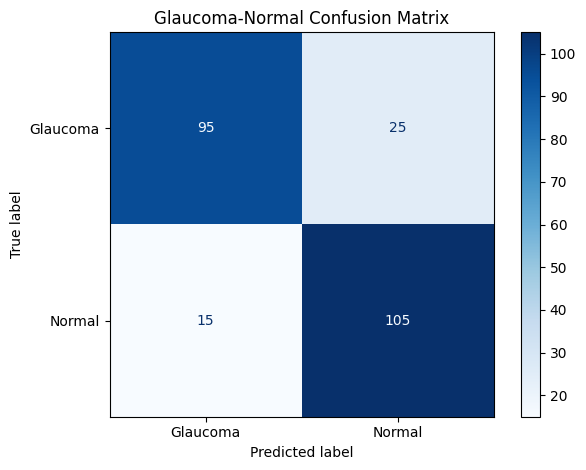

In [108]:
# Plot the confusion matrix

cm = confusion_matrix(y_true_in_numpy, y_pred_in_numpy)

# Create labels for the matrix
labels = list(data_sets['test'].class_indices.keys())

# Plot the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmap = plt.colormaps['Blues']
cmd.plot(cmap=cmap, colorbar=True)
plt.title('Glaucoma-Normal Confusion Matrix')
plt.tight_layout()
plt.show()

### ROC & AUC

In [109]:
fpr, tpr, thresholds = roc_curve(y_true_in_numpy, y_pred_in_numpy)

In [110]:
roc_auc = auc(fpr, tpr)

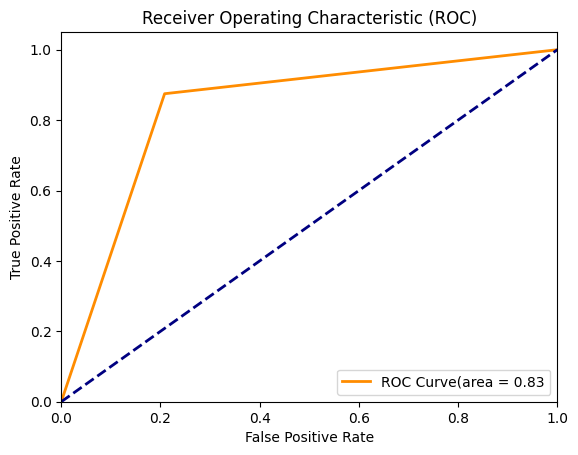

In [111]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC Curve(area = %0.2f' %roc_auc)
plt.plot([0,1], [0,1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc = 'lower right')

In [112]:
roc_auc_score_ = roc_auc_score(y_true_in_numpy, y_pred_in_numpy)
print(f'ROC AUC Score: {roc_auc_score_:.4f}') 

ROC AUC Score: 0.8333


## Save the model

In [67]:
# model.save('')

## Use trained model for prediction

In [68]:
from tensorflow.keras.models import load_model, model_from_json, save_model

saved_model = load_model('D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\trained_model\\efficientnetv2b2_glaucoma_best_model.h5', compile=True)

In [69]:
new_prediction_result = saved_model.predict(data_sets['test'])
print('Number of new predicted images:', len(new_prediction_result))
print('New prediction result:', new_prediction_result)
print('New prediction result shape:', new_prediction_result.shape)

new_predictions_df = pd.DataFrame(new_prediction_result)

8/8 [==============================] - 6s 260ms/step
Number of new predicted images: 240
New prediction result: [[5.35512388e-01]
 [2.25621328e-01]
 [2.47294214e-02]
 [3.63539726e-01]
 [5.91885865e-01]
 [3.26018363e-01]
 [1.15766354e-01]
 [1.86490398e-02]
 [5.87842286e-01]
 [4.57497127e-03]
 [4.73221272e-01]
 [1.24037350e-02]
 [3.54669064e-01]
 [2.45177746e-03]
 [5.07781744e-01]
 [1.31148542e-03]
 [2.17647895e-01]
 [3.45953435e-01]
 [2.44476385e-02]
 [1.77084804e-01]
 [7.54380599e-03]
 [2.69461493e-03]
 [9.40064043e-02]
 [6.72260404e-01]
 [2.91584313e-01]
 [2.59860000e-03]
 [3.35676044e-01]
 [1.06909178e-01]
 [1.17688216e-01]
 [1.21388328e-03]
 [8.70296499e-04]
 [1.62804071e-02]
 [1.65719917e-04]
 [5.59985377e-02]
 [2.22373055e-03]
 [1.97330043e-01]
 [1.18606286e-02]
 [2.29387447e-01]
 [3.40102171e-03]
 [6.33617723e-03]
 [3.39356899e-01]
 [4.67174500e-02]
 [3.80008779e-02]
 [1.76201224e-01]
 [2.98242760e-03]
 [2.48123407e-02]
 [2.78447252e-02]
 [1.17313135e-02]
 [8.15441236e-02]
 [3.15

In [70]:
new_predictions_df

0
0    0.535512
1    0.225621
2    0.024729
3    0.363540
4    0.591886
..        ...
235  0.991057
236  0.702467
237  0.804382
238  0.541179
239  0.858087

[240 rows x 1 columns]

In [71]:
# Converts each predicted value into labels

new_predictions_df['y_pred'] = new_predictions_df[0].apply(lambda x: 1 if x >= 0.5 else 0)
new_predictions_df

0  y_pred
0    0.535512       1
1    0.225621       0
2    0.024729       0
3    0.363540       0
4    0.591886       1
..        ...     ...
235  0.991057       1
236  0.702467       1
237  0.804382       1
238  0.541179       1
239  0.858087       1

[240 rows x 2 columns]

In [72]:
# Add y_true into new_predictions_df

print(data_sets['test'].classes)
new_predictions_df['y_true'] = data_sets['test'].classes
new_predictions_df

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


0  y_pred  y_true
0    0.535512       1       0
1    0.225621       0       0
2    0.024729       0       0
3    0.363540       0       0
4    0.591886       1       0
..        ...     ...     ...
235  0.991057       1       1
236  0.702467       1       1
237  0.804382       1       1
238  0.541179       1       1
239  0.858087       1       1

[240 rows x 3 columns]

In [73]:
new_predictions_df.columns = ['prediction_results', 'y_pred', 'y_true']
new_predictions_df

prediction_results  y_pred  y_true
0              0.535512       1       0
1              0.225621       0       0
2              0.024729       0       0
3              0.363540       0       0
4              0.591886       1       0
..                  ...     ...     ...
235            0.991057       1       1
236            0.702467       1       1
237            0.804382       1       1
238            0.541179       1       1
239            0.858087       1       1

[240 rows x 3 columns]

In [74]:
new_y_pred_in_numpy = np.array(new_predictions_df['y_pred'])
new_y_pred_in_numpy

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [75]:
new_y_true_in_numpy = np.array(new_predictions_df['y_true'])
new_y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [76]:
# Creating CSV file path and its headers

csv_file_path = 'D:\\Kuliah\\Proyek Akhir 2022\\new_test_dataset_glaucoma_normal.csv'
headers = ['Image', 'Label']

In [77]:
# Write the CSV file

with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(headers)

In [78]:
# Fill the CSV file with the image path and their label

supported_extensions = ['.png', '.jpg', '.jpeg']

for root, dirs, files in os.walk('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal) (Splitted)\\test'):
    for file in files:
        if any(file.lower().endswith(ext) for ext in supported_extensions):
            image_path = os.path.join(root, file)
            label = os.path.basename(root)
            with open(csv_file_path, 'a', newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([file, label])

In [79]:
# Load and preview the CSV dataset file

new_test_glaucoma_df = pd.read_csv('D:\\Kuliah\\Proyek Akhir 2022\\new_test_dataset_glaucoma_normal.csv')
new_test_glaucoma_df

Image     Label
0                BEH-147.png  Glaucoma
1                  BEH-3.png  Glaucoma
2              CRFO-v4-4.png  Glaucoma
3              CRFO-v4-8.png  Glaucoma
4    DRISHTI-GS1-test-23.png  Glaucoma
..                       ...       ...
235       REFUGE1-val-74.png    Normal
236     sjchoi86-HRF-130.png    Normal
237     sjchoi86-HRF-131.png    Normal
238     sjchoi86-HRF-193.png    Normal
239      sjchoi86-HRF-87.png    Normal

[240 rows x 2 columns]

Glaucoma    120
Normal      120
Name: Label, dtype: int64

Total predicted images: 240


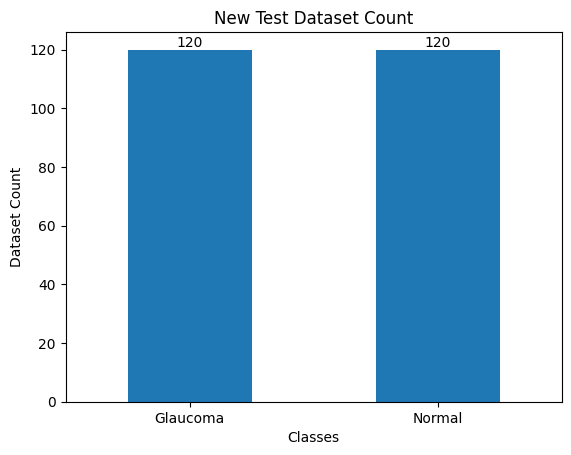

In [80]:
new_test_glaucoma_df['Label'].value_counts()
print(new_test_glaucoma_df['Label'].value_counts())

# View the above in a bar graph
new_test_df_chart = new_test_glaucoma_df.groupby('Label')['Image'].nunique().plot(
    kind='bar',
    title='New Test Dataset Count',
    xlabel='Classes',
    ylabel='Dataset Count',
    rot=0
)

new_test_df_chart.bar_label(new_test_df_chart.containers[0])

# Lets print the total predicted images 
print("\nTotal predicted images:", new_test_glaucoma_df.shape[0])



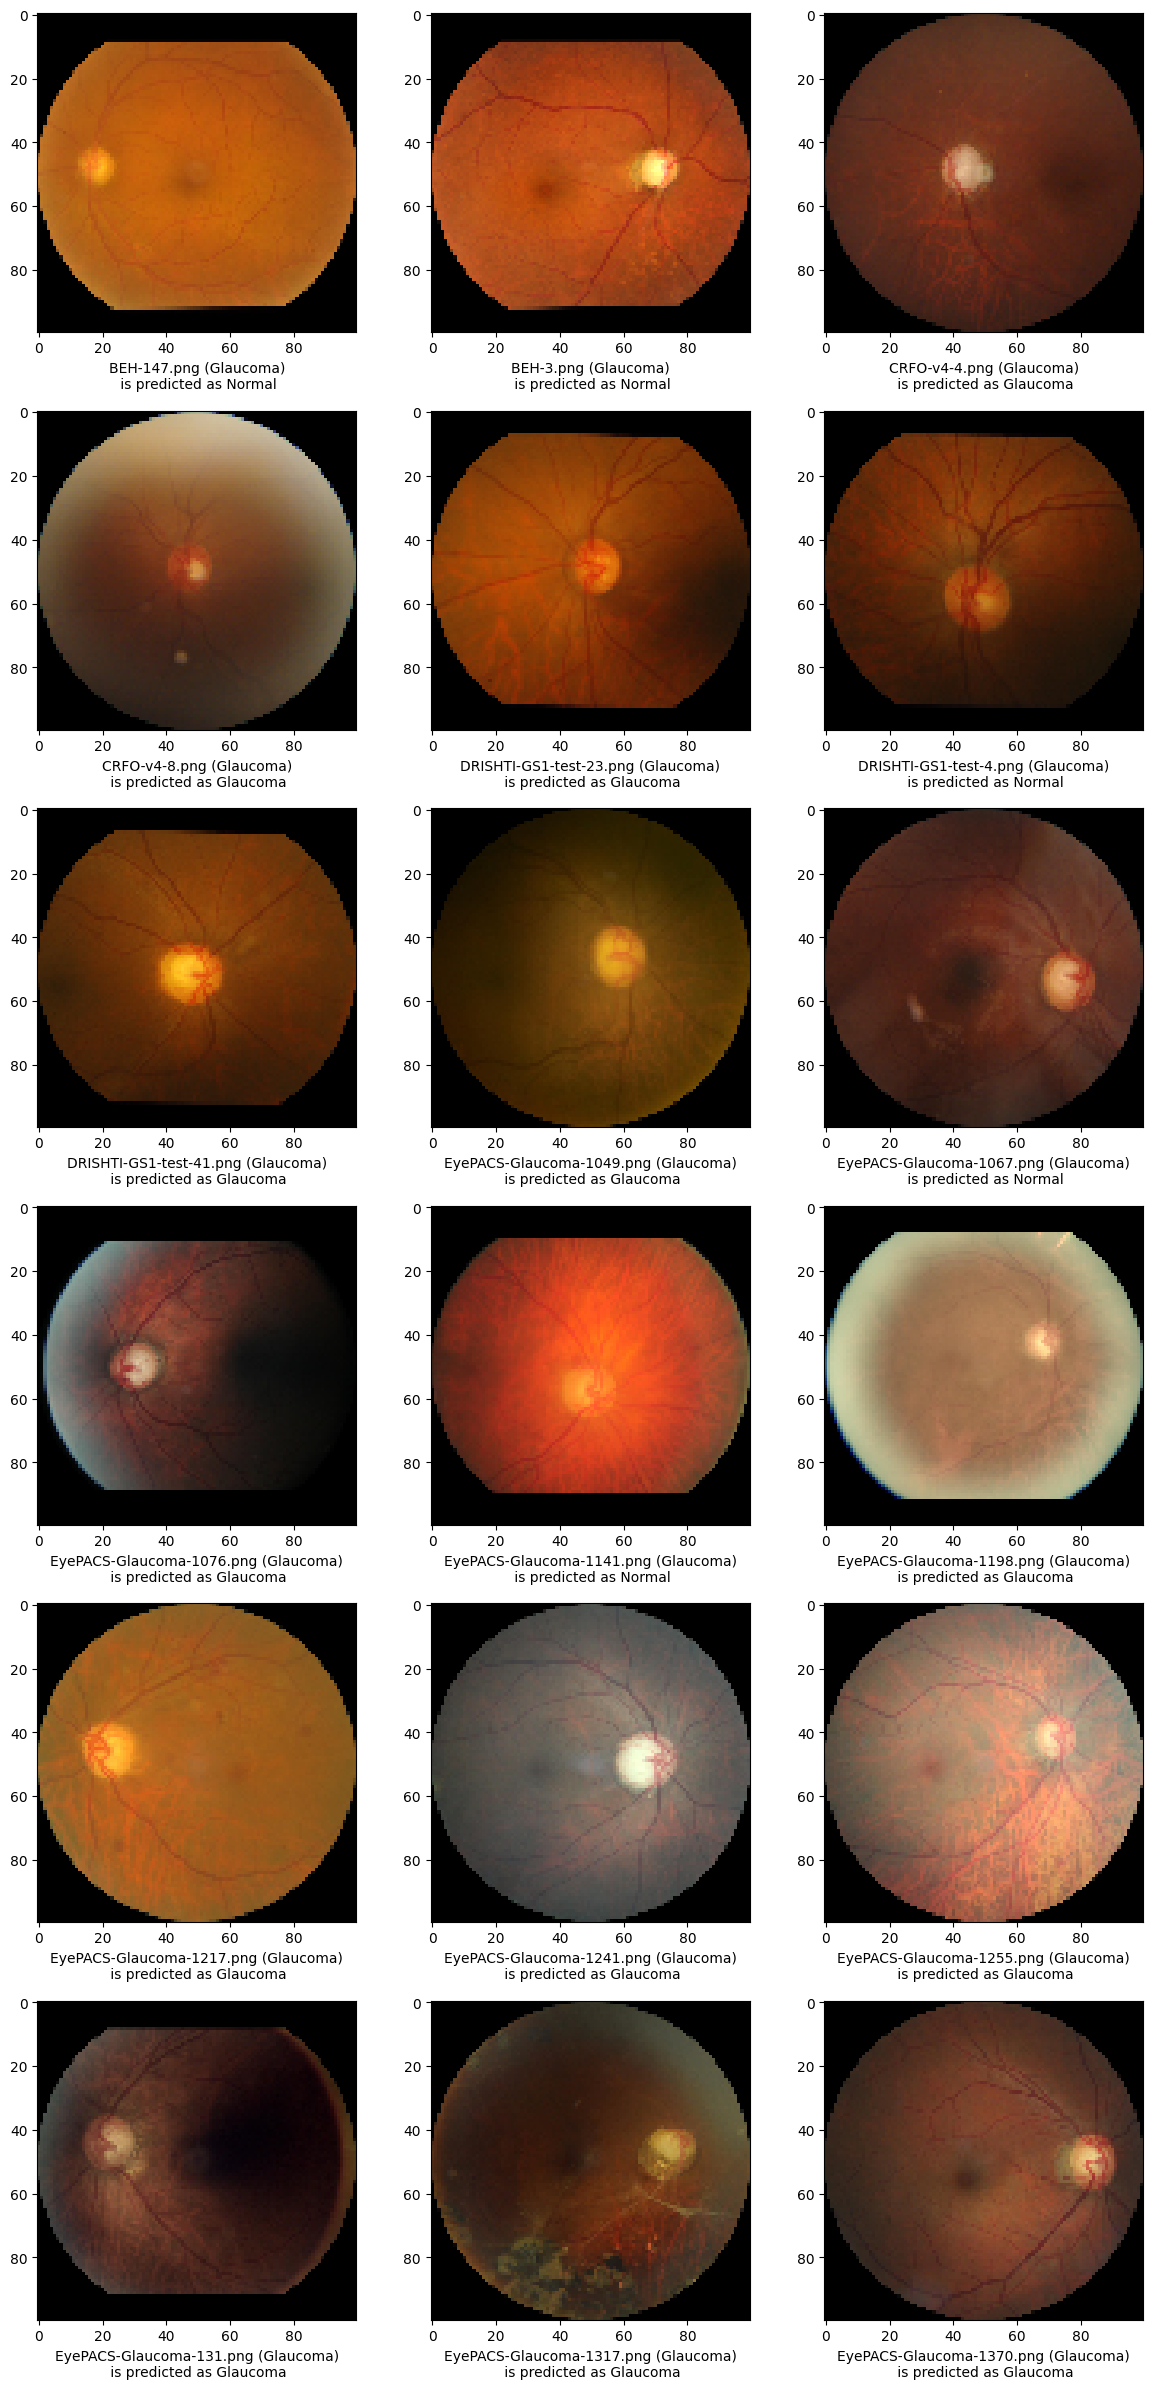

In [81]:
from tensorflow.keras.preprocessing.image import load_img

sample_test = new_test_glaucoma_df.head(18)
sample_test.head()
class_indices = data_sets['test'].class_indices
plt.figure(figsize=(12, 24))

for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['Label']
    y_pred = predictions_df['y_pred'][index]
    classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
    img = load_img('D:\\Kuliah\\Proyek Akhir 2022\\Dataset (Glaucoma-Normal) (Splitted)\\test\\Glaucoma\\' + filename, target_size=IMG_SIZE) #rescale(1./255)
    plt.subplot(6, 3, index+1)      
    plt.imshow(img)
    plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

plt.tight_layout()
plt.show()

In [82]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(new_y_true_in_numpy, new_y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(new_y_true_in_numpy, new_y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(new_y_true_in_numpy, new_y_pred_in_numpy, target_names=class_names))




Accuracy: 0.89

Micro Precision: 0.89
Micro Recall: 0.89
Micro F1-score: 0.89

Macro Precision: 0.89
Macro Recall: 0.89
Macro F1-score: 0.89

Weighted Precision: 0.89
Weighted Recall: 0.89
Weighted F1-score: 0.89


Classification Report

              precision    recall  f1-score   support

    Glaucoma       0.90      0.87      0.89       120
      Normal       0.87      0.91      0.89       120

    accuracy                           0.89       240
   macro avg       0.89      0.89      0.89       240
weighted avg       0.89      0.89      0.89       240



In [83]:
# Let's try, if the model can predict just one image

from tensorflow.keras.preprocessing import image

def predict_one_image(img_path, model=model):
    img = load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)
    
    print(img_array.shape) 
    print(type(img_array))
    
    prediction_result = model.predict(img_array)
    
    print('Prediction_result:', prediction_result)    
    print('Prediction_result shape:', prediction_result.shape)    
    print('Prediction_result type:', type(prediction_result))    

    if prediction_result[0] > 0.5:
        predicted_class = class_names[1]
    else:
        predicted_class = class_names[0]
    
    print('Prediction_class:', predicted_class)

glaucoma_normal_test_image = test_image_source = 'D:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model\\glaucoma_test_images\\mixed - 10 - normal (661).jpg'
predict_one_image(glaucoma_normal_test_image, saved_model)

(1, 100, 100, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 [==============================] - 6s 6s/step
Prediction_result: [[0.68112606]]
Prediction_result shape: (1, 1)
Prediction_result type: <class 'numpy.ndarray'>
Prediction_class: Normal
